In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from sklearn.linear_model import LinearRegression, TheilSenRegressor, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR



from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from itertools import product
import seaborn as sns
import math



In [2]:
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# sns.set(rc={'figure.figsize':(10,4)})


In [51]:
EXPERIMENT_DESCRIPTORS = ['dataset', 'model']

DATASET_ESTIMATORS_CAT = ['model_type', 'data_type']
DATASET_ESTIMATORS_NUM = [
    'n_parameters',
    'datapoint_w', 
    'datapoint_h', 
    'dimensions', 
    'num_classes', 
    'original_data_size'
]

DATASET_ESTIMATORS = [*DATASET_ESTIMATORS_CAT, *DATASET_ESTIMATORS_NUM]


RUN_DESCRIPTORS = [
    'iteration',
    'data_quality_dimension_percentage',
    'loss',
    'categorical_accuracy',
    'categorical_crossentropy',
    'top_3_accuracy',
    'top_5_accuracy',
    'precision',
    'recall',
    'auc',
    'f1_score',
    'effective_epochs',
    'used_data_size',
    'actual_data_percentage_used',
    'emissions_kg',
    'duration',
]


DATASET_TYPE_NAMES = ['images', 'time_series']
DATASET_NAMES = []
MODEL_NAMES = []

MODEL_TYPES = ['SIMPLE_CNN', 'SIMPLE_MLP', 'RESNET', 'Other']
DATA_TYPES = ['Sensor', 'Spectro', 'Image', 'Device', 'Motion', 'EOG', 'Traffic', 'ECG', 'Simulated', 'Spectrum', 'Other']


METRICS = ['f1_score', 'auc', 'categorical_accuracy', 'precision', 'recall']
REDUCING_METHODS = ['keep_distributions', 'balance_classes']
linear_regressors = {'linear': LinearRegression, 'theil': TheilSenRegressor}

regressors = {'random_forest': RandomForestRegressor, 'svr': SVR, 'xgboost': GradientBoostingRegressor}

skip_datasets = [] # ['ECG5000', 'ECGFiveDays', 'Coffee', 'CBF']
skip_models = [] # ['MLP']

SPLIT_PERCENTAGE = 0.3
RUNS_FILE = 'best_50.csv'

In [52]:
cols_to_drop = ['ready', 'loss', 'categorical_crossentropy', 'top_3_accuracy', 'top_5_accuracy', 'project_id', 'duration_per_epoch', 'emissions_per_epoch']
data_location = './../backend/static/experiment_results'
def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]
        
def load_runs(dataset_type):
    """
        Takes all runs from results folders and loads it for analysis
        Return dataframe with runs
    """
    total_df = pd.DataFrame()
    for _, _, files in os.walk(f"{data_location}/{dataset_type}/filtered"):
        for file in files:
#             if file.endswith('results.csv'):
#                 total_df = pd.concat([total_df, pd.read_csv(f"{data_location}/{dataset_type}/{file}")])
            if file.endswith(RUNS_FILE):
                total_df = pd.concat([total_df, pd.read_csv(f"{data_location}/{dataset_type}/filtered/{file}")])
    total_df = total_df.query(f"dataset not in {skip_datasets} and model not in {skip_models}")
    return total_df

def get_unique_experiments(runs_df):
    """
        Array of dataset-model pairs
    """
    return list(runs_df[['dataset', 'model']].drop_duplicates().to_records(index=False))
    
def get_unique_datasets(runs_df):
    return runs_df['dataset'].unique()

def get_reduction_curve(runs_df, metric, regressor):
    assert runs_df['model'].unique().shape[0] == 1
    assert runs_df['dataset'].unique().shape[0] == 1
    

        
    X = np.log(runs_df[['data_quality_dimension_percentage']])
    y = runs_df[metric]
    
    reg = linear_regressor()
    reg.fit(X, y)
    
    return {
        "slope": reg.coef_[0],
        "intercept": reg.intercept_
    }
    



def get_single_experiment_runs(runs_df, model, dataset):
    return runs_df.query(f"model == '{model}' and dataset == '{dataset}'")


def get_train_test_datasets(dataset_list, percentage):
    test_datasets = list(np.random.choice(dataset_list, int(percentage*len(dataset_list))))
    train_datasets = list(set(dataset_list) - set(test_datasets))
    
    return train_datasets, test_datasets


def split_runs_df(runs_df, percentage):
    
    # todo: go back to spliting based on experiments and not only
    dataset_list = get_unique_datasets(runs_df)

    datasets_train, datasets_test = get_train_test_datasets(dataset_list, percentage)
    train_runs_df = runs_df.query(f"dataset in {datasets_train}")
    test_runs_df = runs_df.query(f"dataset in {datasets_test}")
    
    return train_runs_df, test_runs_df

def split_by_experiments_df(experiments_df, percentage):
    
    # todo: go back to spliting based on experiments and not only
    
#     return train_runs_df, test_runs_df
    pass



def load_experiments_df(runs_df, linear_regressor, metrics=None):
    unique_experiments = get_unique_experiments(runs_df)
    result = []
    for dataset, model in unique_experiments:
        experiment_runs_df = get_single_experiment_runs(runs_df, model, dataset)
        base_data = {
            attribute: experiment_runs_df[attribute].unique()[0] for attribute in EXPERIMENT_DESCRIPTORS + DATASET_ESTIMATORS
        }
        for metric in metrics or METRICS:
            curve_data = get_reduction_curve(experiment_runs_df, metric, linear_regressor)
            result.append({**base_data, 'metric': metric, **curve_data})
            
    return pd.DataFrame(result)


def train_regressor_model(experiments_df, metric, regressor, cat_estimators, num_estimators):
    estimating_column = 'slope'
    experiments_df = experiments_df.query(f"metric == '{metric}'")
    
    X_data_cat = None
    X_data_num = None
    encoder = None
    if len(cat_estimators):
        X_data_cat = experiments_df[cat_estimators]
        categories = []
        if 'model_type' in cat_estimators:
            categories.append(MODEL_TYPES)
        if 'data_type' in cat_estimators:
            categories.append(DATA_TYPES)
    
        encoder = OneHotEncoder(handle_unknown='error', categories=categories)
        encoder.fit(X_data_cat)
        X_data_cat = encoder.transform(X_data_cat).toarray()

    if len(num_estimators):
        X_data_num = experiments_df[num_estimators]
    
    X_data = None
    if X_data_cat is not None:
        X_data = X_data_cat
    if X_data_num is not None:
        if X_data is not None:
            X_data = np.concatenate([X_data, X_data_num], axis=1)
        else:
            X_data = X_data_num
            
    y_data = experiments_df[estimating_column]

    regressor = regressor()
    regressor.fit(X_data, y_data)
    
    return regressor, encoder



def evaluate_test_experiment_df(test_experiments_df, metric, encoder, regressor, cat_estimators, num_estimators):
    estimating_column='slope'
    test_experiments_df = test_experiments_df.query(f"metric == '{metric}'")
    
    X_test_cat = None
    X_test_num = None
    if len(cat_estimators):
        X_test_cat =  test_experiments_df[cat_estimators]
        X_test_cat = encoder.transform(X_test_cat).toarray()
        
    if len(num_estimators):
        X_test_num = test_experiments_df[num_estimators]
    
    X_test = None
    if X_test_cat is not None:
        X_test = X_test_cat
    if X_test_num is not None:
        if X_test is not None:
            X_test = np.concatenate([X_test, X_test_num], axis=1)
        else:
            X_test = X_test_num
            
    
    
    y_true = test_experiments_df[estimating_column]
    y_pred = regressor.predict(X_test)
    
    return mean_squared_error(y_true, y_pred)


## Reduction Curve Analysis
- Which reduction curve method to choose

In [53]:
ts_runs_df = load_runs('time_series')

experiments_df = pd.DataFrame()

for linear_regressor_name, linear_regressor in linear_regressors.items():
    experiments_df = pd.concat([
        experiments_df, 
        load_experiments_df(ts_runs_df, linear_regressor).assign(linear_regressor=linear_regressor_name)
    ])

In [54]:
unique_experiment_names = get_unique_experiments(ts_runs_df)

unique_experiment_names.__len__()
# unique_experiment_names

50

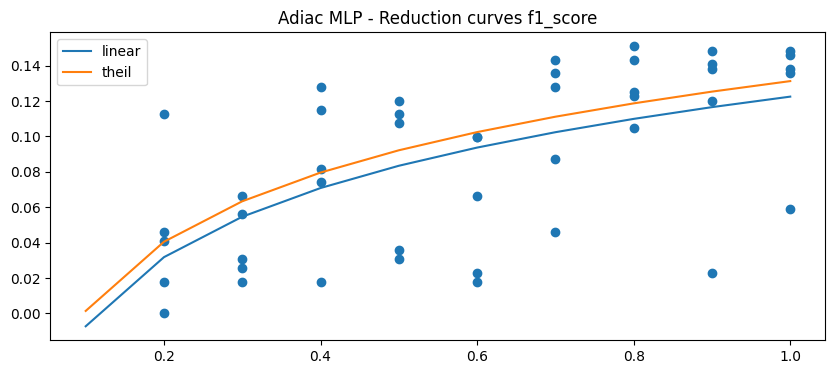

In [55]:
for dataset, model in unique_experiment_names:
    metric = 'f1_score'
    experiment_runs = get_single_experiment_runs(ts_runs_df, model, dataset)
    experiment_reduction_curves_df = get_single_experiment_runs(experiments_df, model, dataset).query(f"metric == '{metric}'")
    X = np.arange(0.1, 1.1, 0.1)
    plt.title(f"{dataset} {model} - Reduction curves {metric}")
    plt.scatter(experiment_runs[['data_quality_dimension_percentage']], experiment_runs[[metric]])

    for i, reduction_curve in experiment_reduction_curves_df.iterrows():
        plt.plot(X, reduction_curve.intercept + reduction_curve.slope*np.log(X), label=f"{reduction_curve.linear_regressor}")
    
    plt.legend()
    plt.show()
    break
    


## Analysing Performance on different Regressor models

- The idea of the tool regressor is to estimate the curve coefficient of a new experiment (model, dataset) + metric, based on its characteristics
- The training set then would be the different experiments with respective curve coefficients

In [8]:
# This block tests the powerset of descriptors, really slow

# results = []

# ts_runs_df = load_runs('time_series')
# num_estimators_set = np.random.choice(list(powerset(DATASET_ESTIMATORS_NUM))[1:], 40, replace=False)

# for _ in tqdm(range(1)):
#     linear_regressor = TheilSenRegressor
#     train_ts_run_df, test_ts_run_df = split_runs_df(ts_runs_df, 0.15)
#     train_ts_experiments_df, test_ts_experiments_df = load_experiments_df(train_ts_run_df, linear_regressor), load_experiments_df(test_ts_run_df, linear_regressor)
#     metric = 'auc'
    
#     regressor_name = 'svr'
#     regressor = regressors[regressor_name]

#     for cat_estimators in tqdm(powerset(DATASET_ESTIMATORS_CAT)):
#         for num_estimators in num_estimators_set:
#             reg, enc = train_regressor_model(train_ts_experiments_df, metric, regressor, cat_estimators, num_estimators)
#             mse = evaluate_test_experiment_df(test_ts_experiments_df, metric, enc, reg, cat_estimators, num_estimators)


#             results.append({
#                 'regressor': regressor_name,
#                 'mse': mse,
#                 'metric': metric,
#                 'cat_estimators': "-".join(cat_estimators),
#                 'num_estimators': "-".join(num_estimators),
#             })

                
# results = pd.DataFrame(results)

# results.boxplot(by=['cat_estimators', 'num_estimators'], rot=90)
# num_estimators_set

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


f1_score    AxesSubplot(0.1,0.77069;0.8x0.12931)
dtype: object

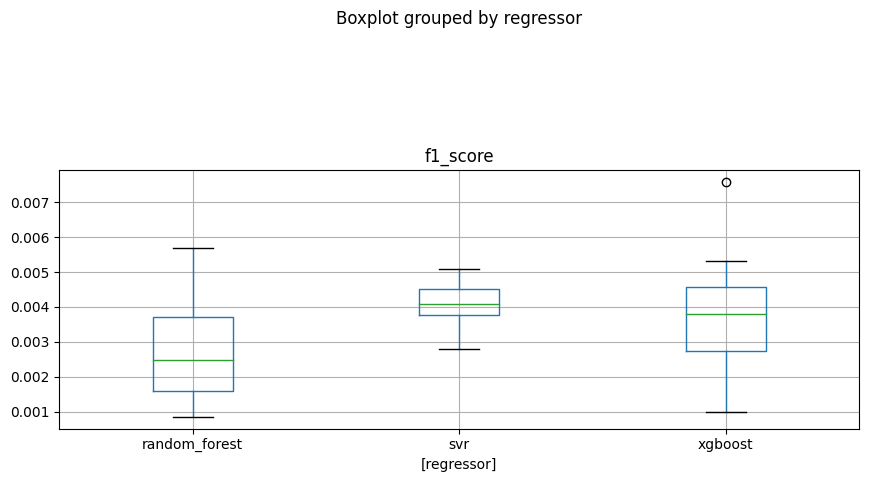

In [56]:
# This block tests the different regression models, also can take a bit
results = []

ts_runs_df = load_runs('time_series')

for _ in tqdm(range(10)):
    linear_regressor = TheilSenRegressor
    train_ts_run_df, test_ts_run_df = split_runs_df(ts_runs_df, SPLIT_PERCENTAGE)
    train_ts_experiments_df, test_ts_experiments_df = load_experiments_df(train_ts_run_df, linear_regressor, ['f1_score']), load_experiments_df(test_ts_run_df, linear_regressor, ['f1_score'])
    
    
    for metric in ['f1_score']: #METRICS
        for regressor_name, regressor in regressors.items():
            reg, enc = train_regressor_model(train_ts_experiments_df, metric, regressor, DATASET_ESTIMATORS_CAT, DATASET_ESTIMATORS_NUM)
            mse = evaluate_test_experiment_df(test_ts_experiments_df, metric, enc, reg, DATASET_ESTIMATORS_CAT, DATASET_ESTIMATORS_NUM)


            results.append({
                'regressor': regressor_name,
                'mse': mse,
                'metric': metric
            })

                
results = pd.DataFrame(results)
results.groupby('metric').boxplot(by=['regressor'], layout=(5,1), figsize=(10, 20), column='mse')


In [57]:
train_ts_experiments_df.shape, test_ts_experiments_df.shape

((39, 13), (11, 13))

## Evaluating on real results

In [61]:
def show_percentage(number):
    return str(100*number)[:4] + "%"

def simulate_user_experiment(full_runs_df, train_experiment_curves_df, user_experiment, estimating, regressor, phase_one_hyperparameter_search_iterations = 100, verbose=False):
    """
        Performs the whole pipeline the user would perform.
        - User inputs an experiment, a goal metric and a baseline 
        - Tool is trained with the whole dataset except user inputed one
    """
    metric = user_experiment['metric']
    base_metric_result_percentage = 0.4
    
    phase_2_hyperparameter_search_iterations = 20
    
    
    """
        First we need to get the runs of the user experiment
        This is real data
    """
    user_experiment_runs_df = full_runs_df.query(f"dataset=='{user_experiment['dataset']}' and model=='{user_experiment['model']}'")
    base_user_experiment_runs_df = user_experiment_runs_df.query(f"data_quality_dimension_percentage == {base_metric_result_percentage}") # Experiments done with 0.4
    full_user_experiment_runs_df = user_experiment_runs_df.query(f"data_quality_dimension_percentage == {1.0}") # Experiments done with 100% of data, for comparison on classic method
    
    
    base_experiment_metric_result =  base_user_experiment_runs_df[metric].mean()
    full_experiment_metric_result =  full_user_experiment_runs_df[metric].mean()
    base_experiment_kg_emissions =  base_user_experiment_runs_df['emissions_kg'].mean()
    full_experiment_kg_emissions =  full_user_experiment_runs_df['emissions_kg'].mean()
    
    goal_metric = min(1, base_experiment_metric_result + 0.10)
    
    if goal_metric > full_experiment_metric_result:
        goal_metric = (base_experiment_metric_result + full_experiment_metric_result)/2
    
    
    """
        This is the tool model, trained with the data of chosen metric (not including user experiment)
    """
    reg, enc = train_regressor_model(train_experiment_curves_df, metric, regressor, DATASET_ESTIMATORS_CAT, DATASET_ESTIMATORS_NUM)
    

    """
        Simulation part where the tool predicts the percentage of the dataset to be used to reach goal
    """
    

    # To input the data into the regressor, we need to encode it correctly with the same trained encoder
    X_test_cat =  user_experiment[DATASET_ESTIMATORS_CAT].to_frame().T
    X_test_num = [user_experiment[DATASET_ESTIMATORS_NUM]]
    

    X_test_cat = enc.transform(X_test_cat).toarray()
    X_test = np.concatenate([X_test_cat, X_test_num], axis=1)
    
    

    # Predict coefficient using the regressor
    metric_coefficient = reg.predict(X_test)[0]


    # Now we use basic linear equation formulas to get the intercept of the curve with user input, then the % of the dataset needed
#     intercept = base_experiment_metric_result - metric_coefficient*base_metric_result_percentage
#     dataset_percent = (goal_metric - intercept)/metric_coefficient
    
    
    intercept = base_experiment_metric_result - metric_coefficient*math.log(base_metric_result_percentage)
    dataset_percent = math.exp((goal_metric - intercept)/metric_coefficient)
    
    
    
    """
        Now that we have the dataset percent out tool suggested, we can get the actual runs with that percentage
    """
    rounded_dataset_percent = min(round(dataset_percent, 1), 1)
    tool_suggested_experiment_runs_df = user_experiment_runs_df.query(f"data_quality_dimension_percentage == {rounded_dataset_percent}")

    tool_suggested_experiment_metric_result =  tool_suggested_experiment_runs_df[metric].mean()
    tool_suggested_experiment_kg_emissions =  tool_suggested_experiment_runs_df['emissions_kg'].mean()
    



    classic_method_emissions = phase_one_hyperparameter_search_iterations*full_experiment_kg_emissions
    our_method_emissions = phase_one_hyperparameter_search_iterations*base_experiment_kg_emissions + phase_2_hyperparameter_search_iterations*tool_suggested_experiment_kg_emissions

    emissions_percentage_change = (our_method_emissions - classic_method_emissions)/classic_method_emissions

    if verbose:
        print(
            f"""
                On dataset {user_experiment['dataset']} model {user_experiment['model']} metric {user_experiment['metric']}
                    ----- User goals ------

                    User goal: {show_percentage(goal_metric)}
                    User Inputs: {show_percentage(base_experiment_metric_result)} on {show_percentage(base_metric_result_percentage)} of the data

                    ----- Prediction -----

                    Our model predicted to use {show_percentage(rounded_dataset_percent)} of dataset

                    ------ Results ----
                    With that amount of data, we got {show_percentage(tool_suggested_experiment_metric_result)}

                    ----- Emissions saved -----

                    Emissions (kg) saved: {classic_method_emissions - our_method_emissions} (negative value is bad)
                    Emissions percentage change: {show_percentage(emissions_percentage_change)} (Negative is a decrease, good)

                    ------ Errors -----
                    Error on goal: {show_percentage(goal_metric - tool_suggested_experiment_metric_result)} (values < 1% are good (and negative better))


                    ------ Extra errors ----
                    Error on classic method (100% of data): {show_percentage(full_experiment_metric_result - tool_suggested_experiment_metric_result)} (smaller is better) 
                \n\n\n
            """)
        
    return {
        # Experiment data
        'model': user_experiment['model'],
        'dataset': user_experiment['dataset'],
        'metric': user_experiment['metric'],
        'phase_one_hyperparameter_search_iterations': phase_one_hyperparameter_search_iterations,

        # User goal
        'base_experiment_metric_result': base_experiment_metric_result,
        'user_goal': goal_metric,
        'user_goal_error': goal_metric - tool_suggested_experiment_metric_result,
        
        # Results
#         'estimated_coefficient': metric_coefficient,
#         'real_coefficient': 
        'tool_suggested_dataset_percent': rounded_dataset_percent,
        'tool_suggested_experiment_metric_result': tool_suggested_experiment_metric_result,

        # Emissions:
        'classic_method_emissions_kg': classic_method_emissions,
        'our_method_emissions_kg': our_method_emissions,
        'emissions_kg_reduction': classic_method_emissions - our_method_emissions,
        'emissions_percentual_change': emissions_percentage_change,
        
        # Extra
        'full_experiment_metric_result': full_experiment_metric_result,
        'performance_loss_vs_full_dataset': full_experiment_metric_result - tool_suggested_experiment_metric_result,
    }


In [62]:
linear_regressor = TheilSenRegressor
train_ts_run_df, test_ts_run_df = split_runs_df(ts_runs_df, SPLIT_PERCENTAGE)
train_ts_experiments_df, test_ts_experiments_df = load_experiments_df(train_ts_run_df, linear_regressor, ['f1_score']), load_experiments_df(test_ts_run_df, linear_regressor, ['f1_score'])

for sample in test_ts_experiments_df.iterrows():
    sample= sample[1]
    estimating = 'slope'
    regressor = regressors['random_forest']
    simulate_user_experiment(ts_runs_df, train_ts_experiments_df, sample, estimating, regressor, 10000, True)
    
    break




                On dataset DistalPhalanxOutlineAgeGroup model FCN metric f1_score
                    ----- User goals ------

                    User goal: 71.4%
                    User Inputs: 69.6% on 40.0% of the data

                    ----- Prediction -----

                    Our model predicted to use 60.0% of dataset

                    ------ Results ----
                    With that amount of data, we got 74.2%

                    ----- Emissions saved -----

                    Emissions (kg) saved: 0.7514277978767976 (negative value is bad)
                    Emissions percentage change: -23.% (Negative is a decrease, good)

                    ------ Errors -----
                    Error on goal: -2.8% (values < 1% are good (and negative better))


                    ------ Extra errors ----
                    Error on classic method (100% of data): -1.0% (smaller is better) 
                



            


In [63]:
results = []
hyper_search_iterations = 100000
linear_regressor = TheilSenRegressor

for _ in tqdm(range(15)):
    
    train_ts_run_df, test_ts_run_df = split_runs_df(ts_runs_df, SPLIT_PERCENTAGE)
    train_ts_experiments_df, test_ts_experiments_df = load_experiments_df(train_ts_run_df, linear_regressor, ['f1_score']), load_experiments_df(test_ts_run_df, linear_regressor, ['f1_score'])

    
    for sample in test_ts_experiments_df.iterrows():
        sample=  sample[1]

        estimating = 'slope'
        regressor = regressors['random_forest']
        result = simulate_user_experiment(ts_runs_df, train_ts_experiments_df, sample, estimating, regressor, hyper_search_iterations, False)
        results.append(result)
        
        
results_df = pd.DataFrame(results)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:21<00:00,  5.43s/it]


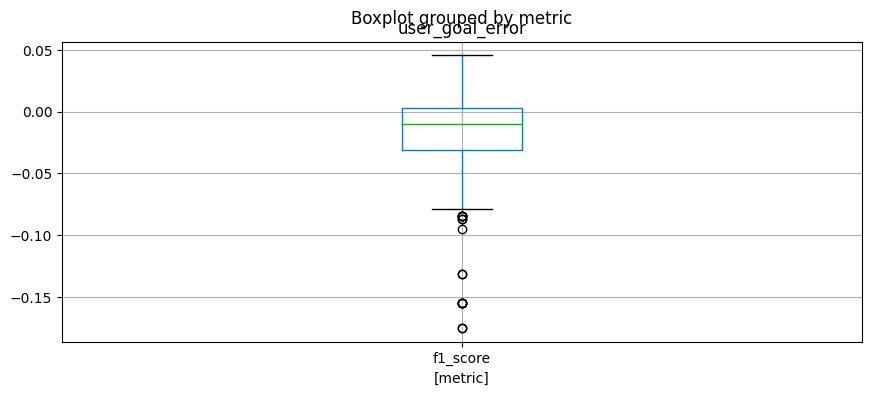

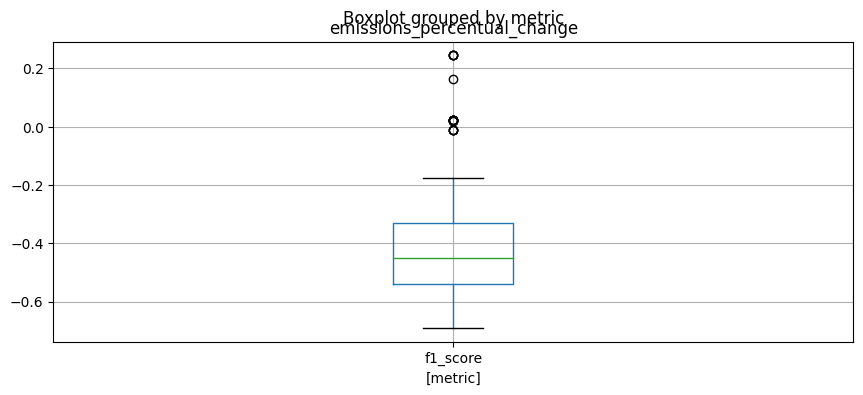

In [64]:
summary_columns = ['user_goal_error', 'emissions_percentual_change']


results_df.query("metric=='f1_score'").boxplot(column=summary_columns[0], by=['metric'])
plt.show()

results_df.query("metric=='f1_score'").boxplot(column=summary_columns[1], by=['metric'])
plt.show()

In [46]:
results_df.groupby(['dataset', 'model'], as_index=False)[['user_goal_error', 'emissions_percentual_change']].mean().sort_values('user_goal_error')

,dataset,model,user_goal_error,emissions_percentual_change
46,WordSynonyms,RESNET,-0.175235,-0.438566
2,ChlorineConcentration,FCN,-0.155365,-0.690615
11,CricketZ,MLP,-0.086667,-0.591047
23,FacesUCR,MLP,-0.084683,-0.176145
3,ChlorineConcentration,RESNET,-0.078646,-0.540632
44,WordSynonyms,FCN,-0.052038,-0.331420
47,WormsTwoClass,MLP,-0.046753,-0.449538
5,CricketX,MLP,-0.046667,-0.496017
24,FacesUCR,RESNET,-0.046439,0.021405
4,CricketX,FCN,-0.037949,-0.451634
